In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import prepare_dataframe, generate_training_dataframe, split_dataframe, manage_prediction, create_real_pred_df, plot_tds, probability_within_radius

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import norm

# North Pacific Ocean Tropical Depressions Novel Forecast Model

## Abstract

Building upon the foundational [analysis of the effects of the El Niño-Southern Oscillation (ENSO) on tropical depressions (TDs) in the North Pacific Ocean](https://github.com/StanDobrev11/enso_effect_on_npacific_tds), this current project takes the research a step further by developing a machine learning (ML) forecast model. The aim is to predict the track, intensity, and progression of tropical depressions based on their initial characteristics and ENSO phases.

In the previous project, correlations between ENSO phases and various tropical depression characteristics, such as frequency, intensity, and storm tracks were successfully identified, especially in the NE Pacific region. It was established that El Niño and La Niña events have discernible impacts on where and how frequently TDs form, as well as their overall intensity across the North Pacific region. This prior work provided valuable insights into how different ENSO conditions influence tropical depressions, laying a strong foundation for more advanced predictive modeling.

## Introduction

### Brief explanation of ENSO and TDs

The **El Niño-Southern Oscillation (ENSO)** is a climate phenomenon characterized by fluctuations in sea surface temperatures and atmospheric conditions in the Pacific Ocean. ENSO consists of three phases: **El Niño**, when ocean waters in the central and eastern Pacific are warmer than average; **La Niña**, when these waters are cooler than normal; and a **Neutral** phase when conditions are closer to the long-term average. ENSO has significant global impacts, affecting weather patterns, rainfall, and storm activity.

A **Tropical Depression (TD)** is a low-pressure weather system that typically develops around 5 degrees north or south of the equator. These systems are the early stage of tropical cyclones and can intensify into stronger storms, such as tropical storms or hurricanes, depending on favorable atmospheric and oceanic conditions. Key factors influencing the development of TDs include sea surface temperature, wind shear, latent heat, moisture, ENSO phase and the Coriolis effect, which helps initiate the system's rotation.

The current project focuses on the development of a machine learning-based forecast model designed to predict the future position, wind speed, and pressure of newly formed tropical depressions at 6-hour intervals. By leveraging historical tropical depression data and known ENSO phases, the model aims to predict the following:

- **TD Track**: The latitudinal and longitudinal coordinates of the storm’s future location.
- **Wind Speed**: Changes in the storm’s wind intensity.
- **Minimum Central Pressure**: Evolution of the storm’s pressure, which is critical for determining its potential strength.
- **Velocity and Direction**: Predict the movement speed and direction of the tropical depression.

Furthermore, as the tropical depression develops, newly acquired data will be incorporated into the model to improve the accuracy of forecasting its further evolution.

### Goals

1. The project aims to develope a series of machine learning models that will predict the future location, wind speed, pressure, and velocity of a tropical depression for the next 6, 12, 18, and 24 hours.
2. Compare the accuracy of different ML models to determine which performs best across varying prediction intervals, with the expectation that the 6-hour prediction will be the most reliable and the 24-hour forecast less so.
3. Evaluate the performance of the models in terms of bias, variance, and overall error using metrics like Mean Squared Error (MSE) and R-squared scores.
4. Optimize the models through grid search and other tuning methods to ensure the best possible performance.

### Steps to be Followed

1. **Data Preparation and Feature Engineering**: The datasets from the previous project will be used. Some of the features will be transformed and scaled, others will be engineered.

2. **Model Selection, Training and Testing**: The machine learning algorithms to be evaluated are Random Forest Regressor and Gradient Boosting Models (XGBoost). The dataset will be split into training and test sets, with cross-validation to ensure model robustness. Separate models will be trained for 6, 12, 18, and 24-hour prediction intervals, with the recursive use of previous predictions for longer intervals.

4. **Model Evaluation**: The performance of the models will be evaluated using metrics such as MSE, R-squared, and bias-variance tradeoffs. The accuracy of the predictions will be analyzed, particularly regarding the 6-hour and 24-hour predictions, with an expectation of decreasing accuracy for longer intervals.

5. **Optimization**: Hyperparameter tuning will be performed using grid search or randomized search to improve the models’ performance, especially in reducing prediction errors.

## Data Preparation and Feature Engineering

### Data Sources

The data used in this project comes from multiple reputable sources, ensuring comprehensive coverage of both tropical depression (TD) activity and environmental factors like sea surface temperature (SST) anomalies:

The SST anomaly data was obtained from the NASA Earth Data AQUA MODIS satellite, providing high-resolution sea surface temperature measurements. These anomalies reflect deviations from normal sea temperatures, which are critical for understanding the effects of El Niño and La Niña events. The data is in .nc format

Data for tropical depressions in the Northwest Pacific was sourced from the Japan Meteorological Agency (JMA). This dataset includes information on each tropical depression's intensity, minimum pressure, wind speeds, latitude, and longitude.

The National Hurricane Center (NHC) provided tropical depression data for the Northeast and Central Pacific, which is similar to the JMA data in terms of recorded metrics like wind speed, pressure, and storm tracks.

The ENSO phases (El Niño, La Niña, and Neutral) were derived from the ONI table provided by the Climate Prediction Center (CPC). The ONI is calculated as the rolling three-month mean SST anomaly in the Niño 3.4 region and is commonly used to identify ENSO phases.

The GSHHS (Global Self-consistent, Hierarchical, High-resolution Shoreline Database) was also utilized in this project to provide accurate geographical boundaries and coastlines for visualizing tropical depression tracks. This dataset offers detailed representations of global shorelines, which are essential for plotting storm trajectories in relation to landmasses and understanding potential landfall locations. GSHHS data ensures that the geospatial analysis of tropical depressions remains accurate and visually consistent when overlaying storm tracks on global maps.

The dataset from the previous project, which includes key information such as TD latitude, longitude, wind speed, minimum central pressure, and ENSO phase, will be further refined. Data cleaning steps included handling missing values, standardizing units, and aligning time formats. The full details of the data cleaning process can be found in the GitHub repository [here](https://github.com/StanDobrev11/enso_effect_on_npacific_tds), where the code for preprocessing is documented and accessible. This ensures the dataset is ready for further analysis and machine learning modeling.

Remaining missing wind data for the JMA dataset will be generated using a Random Forest model, and similarly, missing pressure data for the NHC dataset will be completed using the same method. Additional derived features, such as velocity and direction, will be included, with necessary transformations like trigonometric calculations for geographical coordinates. Features such as latitude, longitude, ENSO phase (one-hot encoded), wind speed, pressure, and the derived velocity and direction will be used to train the models, ensuring a comprehensive representation of tropical depression dynamics.

### Data Preparation

For data preparation, the function **prepare_dataframe()** is imported. Clear explanation of the transformation, performed on the dataframe, are described on the function's docstring. First, we will fill out the missing **wind** values from the JMA dataset.

In [3]:
# read jma data
jma = pd.read_csv('data/csv_ready/jma_td.csv', index_col=0)

# converting the longitude to standart values [-180:180]
jma['lon'] = jma['lon'].apply(lambda x: 360 - x if x > 180 else x)

# drop first row because first and second are same
jma = jma.drop(jma.index[0])

# add values for the wind, assuming minimum wind of the TD to be 35kn
jma.loc[jma['min_pressure_mBar'] >= 980, 'max_wind_kn'] = 35

In [4]:
jma = prepare_dataframe(jma)

In this project, Cartesian coordinates are used to transform the geographical latitude and longitude into a format that is easier for machine learning models to process. Latitude and longitude represent curved surfaces on Earth, but Cartesian coordinates allow the model to work with a flat, linear representation, making it easier to capture spatial relationships in a way that ML algorithms can interpret effectively. This helps improve the accuracy of the predictions.

Transforming the direction into sine and cosine components is done to avoid discontinuities that arise from using angles directly (since 0° and 360° are mathematically the same direction but numerically far apart). By using sine and cosine, the model can treat direction as a smooth, continuous feature, which better represents the cyclical nature of angles and helps improve learning efficiency.

Plane Sailing is a simplified navigational technique used to estimate the course and distance between two points on Earth, assuming that the Earth is flat for small distances. This method works by treating the meridians (lines of longitude) and parallels (lines of latitude) as straight lines, which allows for easy calculations using basic trigonometry. Plane sailing assumes a flat Earth, which introduces only small errors when dealing with short distances. Over small distances, the curvature of the Earth is minimal and can be safely ignored. This makes plane sailing a convenient and fast method for navigation over distances typically less than 600 nautical miles (NM) and therefore, for calculating course and speed of TDs for time intervals of 6 hours.

In the case of tropical depressions (TD), the speed and direction (or velocity and bearing) are relevant to describe the movement from one point to the next. When at point 0 (initial observation), we don't know the speed and direction until next observation position after 6 hours. Shifting the speed and direction by -1 ensures that at each point, the actual speed and direction required to reach the next point are used and the very last observation will have the speed and direction set to 0 to reflect TD's disipation.

In [5]:
jma[:10]

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,direction_sin,direction_cos,x,y,z
date,,,,,,,,,,,,,,
1951-02-19 12:00:00,1,UNNAMED,20.0,138.5,35,1010,-1,45.0,48.0,0.743145,0.669131,-0.703788,0.622659,0.342020
1951-02-19 18:00:00,1,UNNAMED,23.0,142.1,35,1000,-1,40.9,61.0,0.874620,0.484810,-0.726356,0.565453,0.390731
1951-02-20 00:00:00,1,UNNAMED,25.0,146.0,35,994,-1,48.8,58.0,0.848048,0.529919,-0.751363,0.506801,0.422618
1951-02-20 06:00:00,1,UNNAMED,27.6,150.6,35,994,-1,27.1,61.0,0.874620,0.484810,-0.772073,0.435041,0.463296
1951-02-20 12:00:00,1,UNNAMED,28.9,153.3,35,994,-1,43.5,57.0,0.838671,0.544639,-0.782115,0.393363,0.483282
1951-02-20 18:00:00,1,UNNAMED,31.3,157.5,35,992,-1,41.1,72.0,0.951057,0.309017,-0.789417,0.326987,0.519519
1951-02-21 00:00:00,1,UNNAMED,32.6,162.1,35,990,-1,35.1,68.0,0.927184,0.374607,-0.801673,0.258933,0.538771
1951-02-21 06:00:00,1,UNNAMED,33.9,166.0,35,990,-1,38.9,57.0,0.838671,0.544639,-0.805357,0.200798,0.557745
1951-02-21 12:00:00,1,UNNAMED,36.0,170.0,35,990,-1,0.0,0.0,0.000000,1.000000,-0.796726,0.140484,0.587785


In [6]:
# the result of this line shows how many observation are missing wind value
jma.max_wind_kn[jma.max_wind_kn == 0].count()

6743

In [7]:
# separate the dataframe
available_data_jma = jma[jma['max_wind_kn'] > 0]
predicted_data_jma = jma[jma['max_wind_kn'] == 0]

X_raw_jma = available_data_jma[['min_pressure_mBar', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]
y_raw_jma = available_data_jma['max_wind_kn']

# splitting the data 80/20 sounds reasonable. There are abt 62000 valid observations
X_train_jma, X_test_jma, y_train_jma, y_test_jma = train_test_split(X_raw_jma, y_raw_jma, test_size=0.2, random_state=42)
X_pred_jma = predicted_data_jma[['min_pressure_mBar', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]

In [8]:
# building the pipeline
preprocessor_jma = ColumnTransformer([
    ('enso', OneHotEncoder(), ['enso']),
    ('scaler', MinMaxScaler(), ['min_pressure_mBar', 'velocity_kn']),
], remainder='passthrough', force_int_remainder_cols=False)

pipeline_jma = Pipeline([
    ('preprocess', preprocessor_jma),  # Apply scaling and encoding
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=97))
])

Splitting the data 80/20 means using 80% of the dataset (about 49,600 observations) for training the model and the remaining 20% (about 12,400 observations) for testing. This is a common practice to ensure the model has enough data to learn from while still reserving a significant portion for evaluating its performance on unseen data. The train_test_split function with random_state=42 ensures that the split is reproducible, meaning the same split can be obtained each time the code is run.

This pipeline automates the process of preparing the data and training the model for tropical depression forecasting.

First, the preprocessor step handles the data transformations: **ENSO phases** (El Niño, La Niña, Neutral) are one-hot encoded to convert the categorical data into a format that the model can understand.
**MinPressure** and **Velocity** are scaled using **Min-Max scaling** to normalize the values, making them easier for the model to interpret.
Next, the **RandomForestRegressor** is applied to the preprocessed data. This model uses multiple decision trees to predict the next values for wind speed, pressure, and coordinates based on the historical data and ENSO phase. The pipeline combines all of these steps, making it easier to train and test the model efficiently.

Then we fit the training data to the pipeline and evaluate the model:

In [9]:
pipeline_jma.fit(X_train_jma, y_train_jma)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['min_pressure_mBar',
                                                   'velocity_kn'])])),
                ('regressor', RandomForestRegressor(random_state=97))])

In [10]:
pipeline_jma.score(X_test_jma, y_test_jma)

0.990303709781599

In [11]:
y_pred = pipeline_jma.predict(X_test_jma)
print(f'Mean Squared Error: {mean_squared_error(y_test_jma, y_pred)}')

Mean Squared Error: 3.266533927429667


The result shows that the RandomForestRegressor model is performing very well on the test data, with a high accuracy score of 0.99 (which indicates the model is correctly predicting 99% of the variance in the data). The Mean Squared Error (MSE) of 3.26 also indicates that, on average, the model's predictions deviate by about 3.26 units (kn) from the actual values. This is a low error value, further suggesting that the model is making precise predictions. The value of 3.26 kn deviation in the range of 35 - 140 kn of wind is acceptable.

Further evaluation of the model's reliability and potential overfitting will not be conducted, as the model's output is intended solely for a one-time use to fill missing data in the dataset.

With that in mind, missing wind data will be now applied to the jma dataset and will check if there are any '0' values remaining.

In [12]:
predicted_winds = pipeline_jma.predict(X_pred_jma)
jma.loc[jma['max_wind_kn'] == 0, 'max_wind_kn'] = predicted_winds.astype(int)

In [13]:
jma.max_wind_kn[jma.max_wind_kn == 0].count()

0

In [14]:
importances = pipeline_jma.named_steps['regressor'].feature_importances_
feature_names = pipeline_jma.named_steps['preprocess'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                     Feature  Importance
3  scaler__min_pressure_mBar    0.986765
9               remainder__z    0.002938
8               remainder__y    0.002371
7               remainder__x    0.002182
4        scaler__velocity_kn    0.002112
5   remainder__direction_sin    0.001411
6   remainder__direction_cos    0.001330
0              enso__enso_-1    0.000358
2               enso__enso_1    0.000289
1               enso__enso_0    0.000244


The feature importance table shows how much each feature contributes to the model's predictive power. In this case, min_pressure_mBar is the most important feature by far, with a feature importance score of 0.986759. This suggests that the model relies heavily on the minimum central pressure to make accurate predictions. The remaining features, including the x, y, z cartesian coordinates, velocity_kn, direction_sin, direction_cos, and the ENSO phase encoded as one-hot variables, have much lower importance, indicating that their contribution to the model's performance is minimal in comparison. This suggests that the pressure plays a critical role in determining the outcome, while the other features provide only marginal improvements.

A similar operation will be performed on the NHC dataset; however, in this case, the missing values are for minimum central pressure. The pressure values that are to be modeled, have a negative value.

In [15]:
nhc = pd.read_csv('data/csv_ready/ne_pacific_td.csv', index_col=0)
# converting the longitude to standart values [-180:180]
nhc['lon'] = 180 - nhc['lon']

In [16]:
nhc = prepare_dataframe(nhc)

In [17]:
# building the pipeline
preprocessor_nhc = ColumnTransformer([
    ('enso', OneHotEncoder(), ['enso']),
    ('scaler', MinMaxScaler(), ['max_wind_kn', 'velocity_kn']),
], remainder='passthrough', force_int_remainder_cols=False)

pipeline_nhc = Pipeline([
    ('preprocess', preprocessor_nhc),  # Apply scaling and encoding
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=97))
])

In [18]:
# separate the dataframe
available_data_nhc = nhc[nhc['min_pressure_mBar'] > 0]
predicted_data_nhc = nhc[nhc['min_pressure_mBar'] < 0]

X_raw_nhc = available_data_nhc[['max_wind_kn', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]
y_raw_nhc = available_data_nhc['min_pressure_mBar']

# splitting the data 80/20 sounds reasonable. There are abt 62000 valid observations
X_train_nhc, X_test_nhc, y_train_nhc, y_test_nhc = train_test_split(X_raw_nhc, y_raw_nhc, test_size=0.2, random_state=97)
X_pred_nhc = predicted_data_nhc[['max_wind_kn', 'velocity_kn', 'direction_sin', 'direction_cos', 'x', 'y', 'z', 'enso']]

In [19]:
pipeline_nhc.fit(X_train_nhc, y_train_nhc)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['max_wind_kn',
                                                   'velocity_kn'])])),
                ('regressor', RandomForestRegressor(random_state=97))])

In [20]:
pipeline_nhc.score(X_test_nhc, y_test_nhc)

0.9769212339900484

In [21]:
y_pred = pipeline_nhc.predict(X_test_nhc)
print(f'Mean Squared Error: {mean_squared_error(y_test_nhc, y_pred)}')

Mean Squared Error: 7.306479477463594


In [22]:
predicted_pressure = pipeline_nhc.predict(X_pred_nhc)
nhc.loc[nhc['min_pressure_mBar'] < 0, 'min_pressure_mBar'] = predicted_pressure.astype(int)

In [23]:
nhc.min_pressure_mBar[nhc.min_pressure_mBar < 0].count()

0

In [24]:
importances = pipeline_nhc.named_steps['regressor'].feature_importances_
feature_names = pipeline_nhc.named_steps['preprocess'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                    Feature  Importance
3       scaler__max_wind_kn    0.965944
8              remainder__y    0.009226
9              remainder__z    0.008146
7              remainder__x    0.005515
4       scaler__velocity_kn    0.003858
5  remainder__direction_sin    0.002820
6  remainder__direction_cos    0.002698
0             enso__enso_-1    0.000692
1              enso__enso_0    0.000630
2              enso__enso_1    0.000472


Now that the missing values for both datasets, JMA and NHC are completed, they are saved for further usage in ML.

In [25]:
# dropping columns not required and saving the datasets
jma = jma.drop(columns=['direction_sin', 'direction_cos', 'x', 'y', 'z'])
nhc = nhc.drop(columns=['direction_sin', 'direction_cos', 'x', 'y', 'z'])
jma.to_csv('data/csv_ready/jma_training')
nhc.to_csv('data/csv_ready/nhc_training')

## Model Selection, Training & Testing

In the project, Random Forest, Gradient Boosting (XGBoost/LightGBM), and Stochastic Gradient Descent (SGDRegressor) are selected for time series prediction of tropical depression (TD) tracks and intensity due to their strong performance in handling non-linear relationships and structured time series data. These models are well-suited for working with both categorical and continuous features, such as ENSO phase, latitude, longitude, wind speed, and pressure, which are key components of this study.

**How the Training Is Set Up**:

For each observation, the speed and course (direction) were calculated based on the previous position using plain sailing.
Then, these speed and course values were shifted to the previous row, so the course and speed reflect how the storm moved to the current position from the previous one.

For example:
```
1951-05-03 18:00:00	4	IRI	11.4	130.4	104	909	-1	13.4	307.0
1951-05-04 00:00:00	4	IRI	12.2	129.3	110	910	-1	15.0	258.0
1951-05-04 06:00:00	4	IRI	11.9	127.8	109	909	-1	10.6	248.0
```
In the observation at 1951-05-03 18:00:00, the speed is 13.4 knots and the course 307.0 degrees.
This is the speed and course that the storm took to get to the position on 1951-05-04 00:00:00.

The next observation at 1951-05-04 00:00:00 shows a new speed and course for the next 6-hour movement.

**During Prediction**:

When we predict for the next position (e.g., 1951-05-04 06:00:00), the current speed and course represent how the storm arrived at the current position.

So, for prediction, the input should include the speed and course that correspond to the movement toward the current position, because we are essentially asking the model: "Given that the storm traveled to the current position at this speed and course, where will it be in the next 6 hours?"

In this case, the data for prediction should look like this:
```
1951-05-03 18:00:00	4	IRI	11.4	130.4	104	909	-1	0       0
1951-05-04 00:00:00	4	IRI	12.2	129.3	110	910	-1	13.4	307.0
1951-05-04 06:00:00	4	IRI	11.9	127.8	109	909	-1	15.0	258.0
```

### Random Forest for Time Series

Random Forest is ideal for this project due to its robustness in capturing non-linear relationships between multiple variables like ENSO phases, wind speed, pressure, and geospatial data (latitude and longitude). By incorporating lagged features (previous time steps of lat/lon, wind speed, pressure), Random Forest can predict future locations and intensities of tropical depressions with high accuracy. Additionally, its ability to provide interpretable results through feature importance will allow us to understand which factors are most critical in influencing TD development and movement.

However, **Random Forest** requires careful feature engineering, such as generating lag features and applying trigonometric transformations to latitude/longitude to maintain spatial consistency. Transformation of geographical coordinates (latitude and longitude) and direction into sine and cosine components is necessary to avoid treating these as independent variables.

### Gradient Boosting (XGBoost/LightGBM)

Gradient Boosting algorithms, particularly XGBoost and LightGBM, offer higher accuracy and efficiency, especially with larger datasets. Given the structured and complex nature of the time series data in this project, including multiple features like wind, pressure, velocity, and geographic location, Gradient Boosting is a powerful method for handling this complexity. It is particularly useful when combined with careful feature engineering, such as lagged features and trigonometric transformations for geographic data.

However, **XGBoost and LightGBM** require more intensive hyperparameter tuning compared to Random Forest, which can be time-consuming but necessary to achieve optimal results. Similar to Random Forest, these models also require careful engineering of lagged features and transformations for latitude and longitude to capture the spatial relationships of tropical depressions.


### Stochastic Gradient Descent (SGDRegressor)

SGDRegressor is another method incorporated into the model selection due to its computational efficiency and ability to scale well with large datasets, which is crucial for time series data that involve numerous observations like TD tracks. SGDRegressor is a linear model optimized via stochastic gradient descent and is particularly effective in scenarios where the data is large and sparse.

For this project, **SGDRegressor** is beneficial for making fast predictions and learning iteratively over time-series data, especially when feature sets are large and complex. While not as adept at handling non-linear relationships out-of-the-box compared to Random Forest and Gradient Boosting, the linear nature of SGDRegressor can be leveraged when combined with:

- Polynomial Features: To introduce non-linearity by adding interaction terms.
- Feature Scaling: Ensuring that all features like latitude, longitude, wind speed, and pressure are normalized to ensure faster convergence during training.
Moreover, SGDRegressor can benefit from incremental learning, meaning it can be updated with new data as it arrives (e.g., real-time tropical depression data), making it a good fit for a project where data evolves over time. However, SGDRegressor is more sensitive to hyperparameter tuning (e.g., learning rate, regularization strength), and it may require careful tuning to avoid issues like underfitting or overfitting. In this context, the model may require careful tuning of regularization parameters (e.g., L2 regularization), learning rate, and iteration count to ensure accurate predictions for TD tracks and intensities.

**Workflow**
1. Data Preparation
- prep_data: This is a custom function, passed to the pipeline via the FunctionTransformer. It handles essential preprocessing, such as cleaning and extracting relevant features, ensuring the data is ready for model training.
- prep_train_data: Another custom function transformer that prepares the training dataset, handling transformations such as shifting velocity and direction for consistency and ensuring target variables are correctly aligned for supervised learning.

2. Preprocessing and Feature Engineering
- One-Hot Encoding of ENSO Phases: The ENSO (El Niño–Southern Oscillation) phases significantly affect the behavior of tropical depressions. To capture this, we apply one-hot encoding to the enso column. This process transforms categorical data into a binary matrix, where each phase (El Niño, La Niña, Neutral) is represented as a separate binary feature. One-hot encoding ensures that the categorical nature of ENSO is well-represented in the model without introducing unintended ordinal relationships.

- Polynomial Features: To capture non-linear relationships between features, PolynomialFeatures with a degree of 3 are applied to all columns. These polynomial features allow the model to detect complex, higher-order interactions between variables, which could be crucial for accurately predicting the trajectory and intensity of tropical depressions.

3. Feature Scaling:
After polynomial features are generated, we apply MinMaxScaler to all relevant features. This ensures that all variables are on the same scale, which is particularly important for machine learning algorithms like SGDRegressor, which are sensitive to feature scaling. The scaling operation ensures that no feature dominates the learning process due to its magnitude.

4. Model Training: SGDRegressor with Grid Search

We use SGDRegressor as the primary learning algorithm for the model, wrapped in a MultiOutputRegressor to handle multiple output features (latitude, longitude, wind speed, etc.). The SGDRegressor is trained with the following hyperparameters:
- learning_rate: Adaptive, to adjust learning rate over time.
- penalty: L1 regularization, to enforce sparsity and prevent overfitting.
- alpha: Small value to control the strength of the regularization.
- max_iter: Set to 3000 iterations to allow for sufficient training convergence.
- tol: Tolerance for optimization stopping criteria.

A Grid Search was conducted to fine-tune these hyperparameters, optimizing performance and avoiding overfitting.

5. Data Splitting and Model Evaluation

The dataset is split into training and testing sets using a custom split_dataframe function with GroupShuffleSplit (gss). This ensures that all observations for a given tropical depression (grouped by ID) are kept together during the split. This approach prevents data leakage between training and test sets.

6. Training and Scoring:

After preprocessing, the pipeline is fit on the training data (X_train, y_train). The model is then evaluated using the test set (X_test, y_test), achieving a score of 83.85%. This accuracy is considered good for predicting the position, wind speed, and pressure of tropical depressions over the next 6-hour interval.

7. Visualization and Tracking of Predicted vs. Real Positions

To evaluate the model visually, the function plot_tds is used to plot the predicted and real tracks of the tropical depressions. The accuracy of predicted positions over the next 6 hours appears to match well with the real observations, indicating good performance of the model in predicting future positions.

In [26]:
df = pd.read_csv('data/csv_ready/jma_training', index_col=0)

In [27]:
prep_data = FunctionTransformer(func=prepare_dataframe)
prep_train_data = FunctionTransformer(func=generate_training_dataframe)

In [28]:
preprocessor = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),  # One-hot encode the ENSO feature
        ('poly', PolynomialFeatures(degree=3, include_bias=False), slice(0, None)),
    ], remainder='passthrough', force_int_remainder_cols=False)
scaler = MinMaxScaler()
regressor = MultiOutputRegressor(SGDRegressor(learning_rate='adaptive', max_iter=3000, penalty='l1', alpha=1e-6, tol=1e-5, random_state=97))

In [29]:
jma_pred_pipeline_sgd = Pipeline([
        ('prep_data', prep_data),
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('regressor', regressor)
    ])

jma_train_pipeline_sgd = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('regressor', regressor)
    ])

In [30]:
df_trn = prep_data.transform(df)

In [31]:
df_trn = prep_train_data.transform(df_trn)
X_train, X_test, y_train, y_test = next(split_dataframe(df_trn, splitter='gss'))

In [32]:
jma_train_pipeline_sgd.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  slice(0, None, None))])),
                ('scaler', MinMaxScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(alpha=1e-06,
                                                             learning_rate='adaptive',
                                                             max_iter=3000,
                                                             penalty='l1',
                                                             random_state=97,
                                                             tol=1e-05)))])

In [33]:
jma_train_pipeline_sgd.score(X_test, y_test)

0.8662200023169744

In [34]:
X_test.head()

,x,y,z,max_wind_kn,min_pressure_mBar,velocity_kn,direction_sin,direction_cos,enso
date,,,,,,,,,
1951-04-28 12:00:00,-0.813209,0.571533,0.109734,35,1008,4.0,-1.000000,-1.836970e-16,-1
1951-04-28 18:00:00,-0.809199,0.577196,0.109734,35,1006,5.4,-0.927184,3.746066e-01,-1
1951-04-29 00:00:00,-0.803817,0.584007,0.113203,35,1003,5.1,-0.981627,1.908090e-01,-1
1951-04-29 06:00:00,-0.798530,0.590881,0.114937,35,1003,7.2,-0.829038,5.591929e-01,-1
1951-04-29 12:00:00,-0.791639,0.598712,0.121869,35,1002,7.8,-0.642788,7.660444e-01,-1


In [35]:
jma = pd.read_csv('data/csv_ready/jma_training', index_col=0)

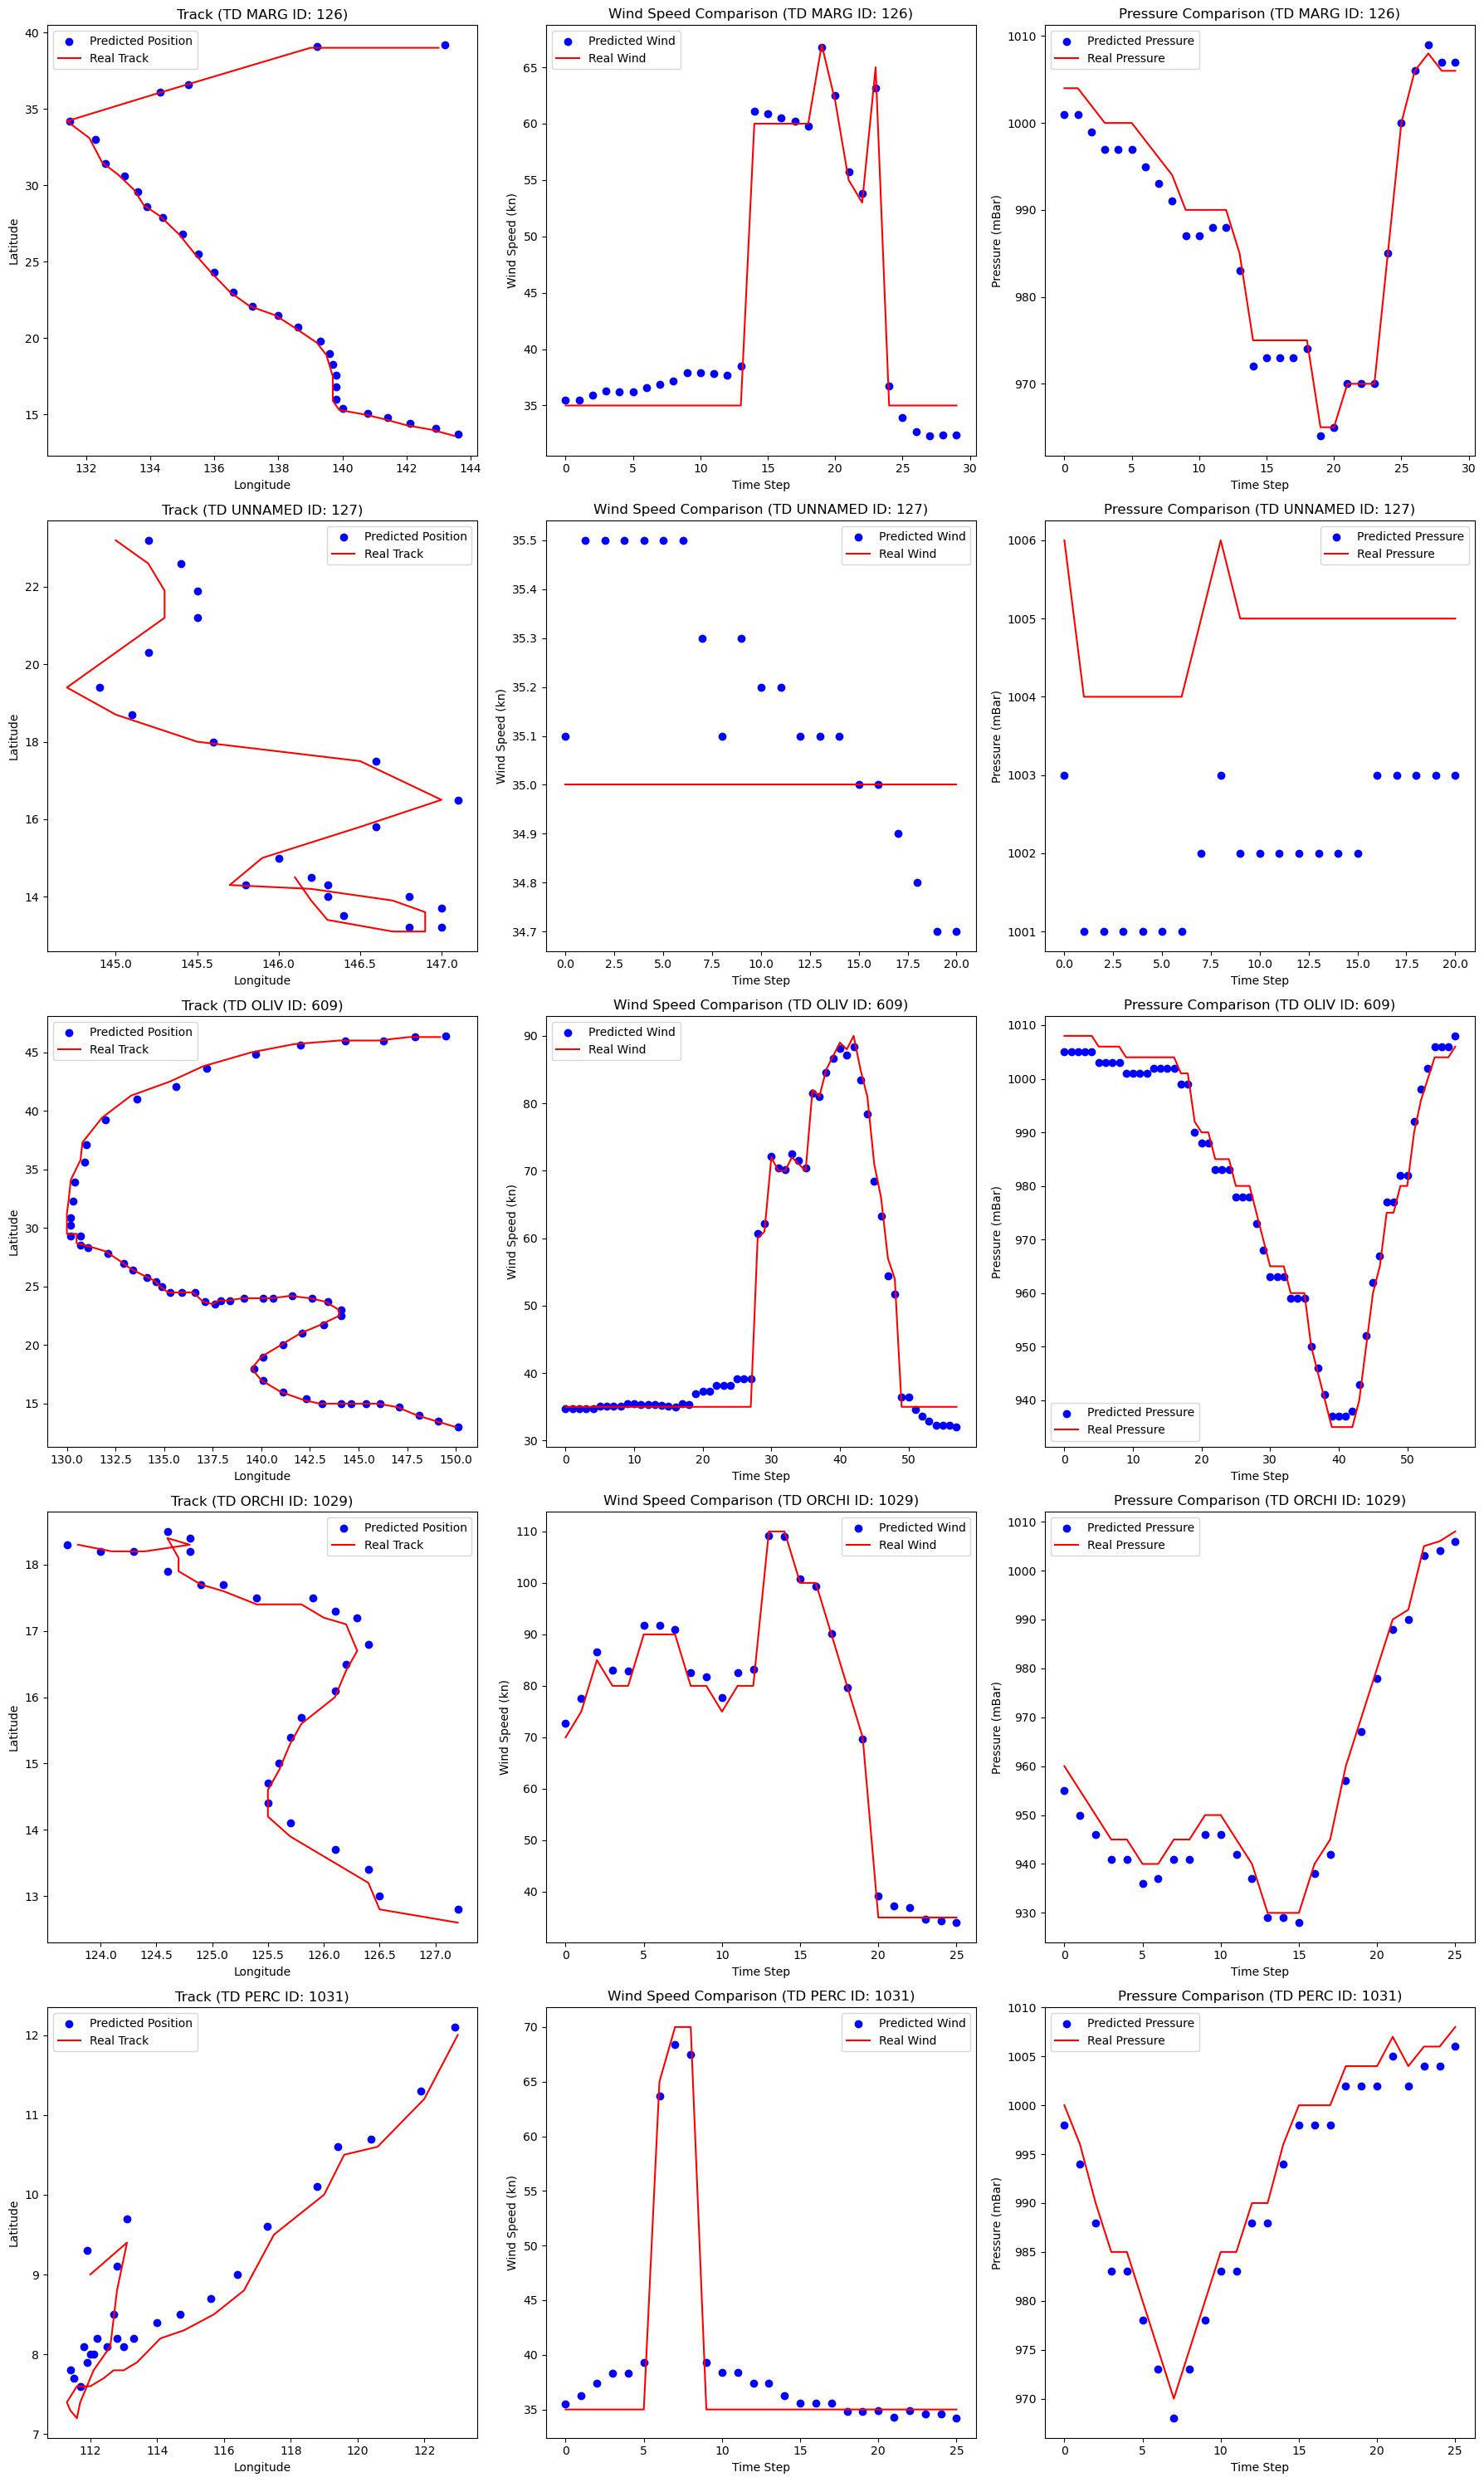

In [36]:
plot_tds(jma, X_test, model=jma_pred_pipeline_sgd, n_samples=3, random_state=97)

In [37]:
y_test

,next_x,next_y,next_z,next_max_wind_kn,next_min_pressure_mBar,next_velocity_kn,next_direction_sin,next_direction_cos
date,,,,,,,,
1951-04-28 12:00:00,-0.809199,0.577196,0.109734,35.0,1006.0,5.4,-0.927184,0.374607
1951-04-28 18:00:00,-0.803817,0.584007,0.113203,35.0,1003.0,5.1,-0.981627,0.190809
1951-04-29 00:00:00,-0.798530,0.590881,0.114937,35.0,1003.0,7.2,-0.829038,0.559193
1951-04-29 06:00:00,-0.791639,0.598712,0.121869,35.0,1002.0,7.8,-0.642788,0.766044
1951-04-29 12:00:00,-0.785330,0.604785,0.132256,35.0,1002.0,8.5,-0.809017,0.587785
...,...,...,...,...,...,...,...,...
2023-10-14 12:00:00,-0.716535,0.152304,0.680721,77.0,950.0,24.6,0.819152,0.573576
2023-10-14 18:00:00,-0.706486,0.114426,0.698415,77.0,952.0,29.5,0.990268,0.139173
2023-10-15 00:00:00,-0.707985,0.063186,0.703395,75.0,954.0,30.7,0.992546,0.121869


In [38]:
X_pred = jma[jma.index == '2023-10-14 18:00:00']

In [39]:
X_expected = jma[jma.index == '2023-10-15 00:00:00']

In [40]:
X_pred

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
2023-10-14 18:00:00,2228,BOLAVE,42.9,168.0,77,950,-1,24.6,55.0


In [41]:
X_expected

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
2023-10-15,2228,BOLAVE,44.3,170.8,77,952,-1,29.5,82.0


In [42]:
jma_pred_pipeline_sgd.predict(X_pred)

array([[-7.09717399e-01,  1.52093217e-01,  6.81847347e-01,
         7.36396802e+01,  9.54942047e+02,  2.45688367e+00,
         6.55972477e-02,  7.71443173e-01]])

In [43]:
manage_prediction(X_pred, jma_pred_pipeline_sgd)

(43.0, 167.9, 73.6, 954, 2.5, 4)

In [44]:
df_ = create_real_pred_df(jma, X_test, model=jma_pred_pipeline_sgd, n_samples=3, random_state=97)

**Method to Calculate Probability of Predicted Position**

To calculate the probability of the predicted position being within a certain range of the actual position, we can use a statistical approach based on error distributions. The error distribution is calculated between predicted and real positions for the test dataset. Then we fit a normal distribution to the error values in terms of latitude and longitude differences. The standard deviation (σ) of the error distribution is used to estimate the confidence interval.

Using the fitted distribution, we calculate the probability that the actual position falls within a certain radius of the predicted position.



In [45]:
df_= probability_within_radius(df_, 10)

In [46]:
df_.probability_within_radius.min(), df_.probability_within_radius.max()

(0.02573685002007157, 0.9996214849351386)

In [47]:
df_[df_.group == 127]

,group,name,real_lat,real_lon,real_max_wind_kn,real_min_pressure_mBar,real_velocity_kn,real_direction_deg,pred_lat,pred_lon,pred_max_wind_kn,pred_min_pressure_mBar,expected_velocity_kn,expected_direction_deg,probability_within_radius
date,,,,,,,,,,,,,,,
1955-10-02 00:00:00,127,UNNAMED,14.5,146.1,35,1006,6.3,198.0,14.5,146.2,35.1,1003,87.7,173.0,0.992051
1955-10-02 06:00:00,127,UNNAMED,13.9,146.2,35,1004,6.1,171.0,14.0,146.3,35.5,1001,5.4,159.0,0.976752
1955-10-02 12:00:00,127,UNNAMED,13.4,146.3,35,1004,5.1,169.0,13.5,146.4,35.5,1001,4.4,154.0,0.976673
1955-10-02 18:00:00,127,UNNAMED,13.1,146.7,35,1004,4.9,128.0,13.2,146.8,35.5,1001,5.3,112.0,0.976628
1955-10-03 00:00:00,127,UNNAMED,13.1,146.9,35,1004,1.9,90.0,13.2,147.0,35.5,1001,3.1,71.0,0.976628
1955-10-03 06:00:00,127,UNNAMED,13.6,146.9,35,1004,5.0,0.0,13.7,147.0,35.5,1001,6.1,9.0,0.976705
1955-10-03 12:00:00,127,UNNAMED,13.9,146.7,35,1004,3.6,327.0,14.0,146.8,35.5,1001,4.1,346.0,0.976752
1955-10-03 18:00:00,127,UNNAMED,14.2,146.2,35,1005,5.7,302.0,14.3,146.3,35.3,1002,5.6,316.0,0.976800
1955-10-04 00:00:00,127,UNNAMED,14.3,145.7,35,1006,4.9,282.0,14.3,145.8,35.1,1003,4.0,284.0,0.992032


In [48]:
X_test

,x,y,z,max_wind_kn,min_pressure_mBar,velocity_kn,direction_sin,direction_cos,enso
date,,,,,,,,,
1951-04-28 12:00:00,-0.813209,0.571533,0.109734,35,1008,4.0,-1.000000,-1.836970e-16,-1
1951-04-28 18:00:00,-0.809199,0.577196,0.109734,35,1006,5.4,-0.927184,3.746066e-01,-1
1951-04-29 00:00:00,-0.803817,0.584007,0.113203,35,1003,5.1,-0.981627,1.908090e-01,-1
1951-04-29 06:00:00,-0.798530,0.590881,0.114937,35,1003,7.2,-0.829038,5.591929e-01,-1
1951-04-29 12:00:00,-0.791639,0.598712,0.121869,35,1002,7.8,-0.642788,7.660444e-01,-1
...,...,...,...,...,...,...,...,...,...
2023-10-14 12:00:00,-0.736372,0.202831,0.645458,76,950,37.1,0.681998,7.313537e-01,-1
2023-10-14 18:00:00,-0.716535,0.152304,0.680721,77,950,24.6,0.819152,5.735764e-01,-1
2023-10-15 00:00:00,-0.706486,0.114426,0.698415,77,952,29.5,0.990268,1.391731e-01,-1


In [49]:
X_test[X_test.velocity_kn > 15][30:50]

,x,y,z,max_wind_kn,min_pressure_mBar,velocity_kn,direction_sin,direction_cos,enso
date,,,,,,,,,
1952-10-04 12:00:00,-0.780985,0.194721,0.593419,35,1004,16.9,0.956305,-2.923717e-01,1
1952-10-05 00:00:00,-0.794950,0.150207,0.587785,35,1008,16.9,0.809017,5.877853e-01,1
1952-10-09 06:00:00,-0.682677,0.531450,0.501511,35,998,22.5,0.529919,8.480481e-01,1
1952-10-09 12:00:00,-0.681709,0.504438,0.529919,35,995,21.5,0.669131,7.431448e-01,1
1952-10-09 18:00:00,-0.683953,0.475359,0.553392,35,995,19.1,0.777146,6.293204e-01,1
1952-10-10 00:00:00,-0.688674,0.447230,0.570714,35,995,24.0,0.777146,6.293204e-01,1
1952-10-10 06:00:00,-0.692979,0.411461,0.592013,35,1000,27.4,0.788011,6.156615e-01,1
1952-10-10 12:00:00,-0.695772,0.369949,0.615661,35,1000,23.5,0.829038,5.591929e-01,1
1952-10-10 18:00:00,-0.698457,0.333147,0.633381,35,1000,16.9,0.913545,4.067366e-01,1


In [50]:
X_pred

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
2023-10-14 18:00:00,2228,BOLAVE,42.9,168.0,77,950,-1,24.6,55.0


In [51]:
X_pred = jma[jma.index == '1952-10-11 12:00:00']
X_expected = jma[jma.index == '1952-10-11 18:00:00']
manage_prediction(X_pred, jma_pred_pipeline_sgd)

(41.9, 160.4, 31.4, 1014, 3.2, 10)

In [52]:
X_expected

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
1952-10-11 18:00:00,41,ROS,41.0,162.0,35,1014,1,15.1,90.0


### RandomForest

In [65]:
preprocessor_rf = ColumnTransformer([
        ('enso', OneHotEncoder(), ['enso']),  # One-hot encode the ENSO feature
        ('poly', PolynomialFeatures(degree=3, include_bias=False), slice(0, None)),
    ], remainder='passthrough', force_int_remainder_cols=False)
scaler = MinMaxScaler()

In [66]:
regressor_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=97))

In [67]:
jma_pred_pipeline_rf = Pipeline([
        ('prep_data', prep_data),
        ('preprocessor', preprocessor_rf),
        ('scaler', scaler),
        ('regressor', regressor_rf)
    ])

jma_train_pipeline_rf = Pipeline([
        ('preprocessor', preprocessor_rf),
        ('scaler', scaler),
        ('regressor', regressor_rf)
    ])

In [68]:
X_train, X_test, y_train, y_test = next(split_dataframe(df_trn, splitter='gss'))

In [69]:
jma_train_pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('enso', OneHotEncoder(),
                                                  ['enso']),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  slice(0, None, None))])),
                ('scaler', MinMaxScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=RandomForestRegressor(random_state=97)))])

In [70]:
jma_train_pipeline_rf.score(X_test, y_test)

0.8643013762733468

In [71]:
jma = pd.read_csv('data/csv_ready/jma_training', index_col=0)

In [72]:
X_test

,x,y,z,max_wind_kn,min_pressure_mBar,velocity_kn,direction_sin,direction_cos,enso
date,,,,,,,,,
1951-04-28 12:00:00,-0.813209,0.571533,0.109734,35,1008,4.0,-1.000000,-1.836970e-16,-1
1951-04-28 18:00:00,-0.809199,0.577196,0.109734,35,1006,5.4,-0.927184,3.746066e-01,-1
1951-04-29 00:00:00,-0.803817,0.584007,0.113203,35,1003,5.1,-0.981627,1.908090e-01,-1
1951-04-29 06:00:00,-0.798530,0.590881,0.114937,35,1003,7.2,-0.829038,5.591929e-01,-1
1951-04-29 12:00:00,-0.791639,0.598712,0.121869,35,1002,7.8,-0.642788,7.660444e-01,-1
...,...,...,...,...,...,...,...,...,...
2023-10-14 12:00:00,-0.736372,0.202831,0.645458,76,950,37.1,0.681998,7.313537e-01,-1
2023-10-14 18:00:00,-0.716535,0.152304,0.680721,77,950,24.6,0.819152,5.735764e-01,-1
2023-10-15 00:00:00,-0.706486,0.114426,0.698415,77,952,29.5,0.990268,1.391731e-01,-1


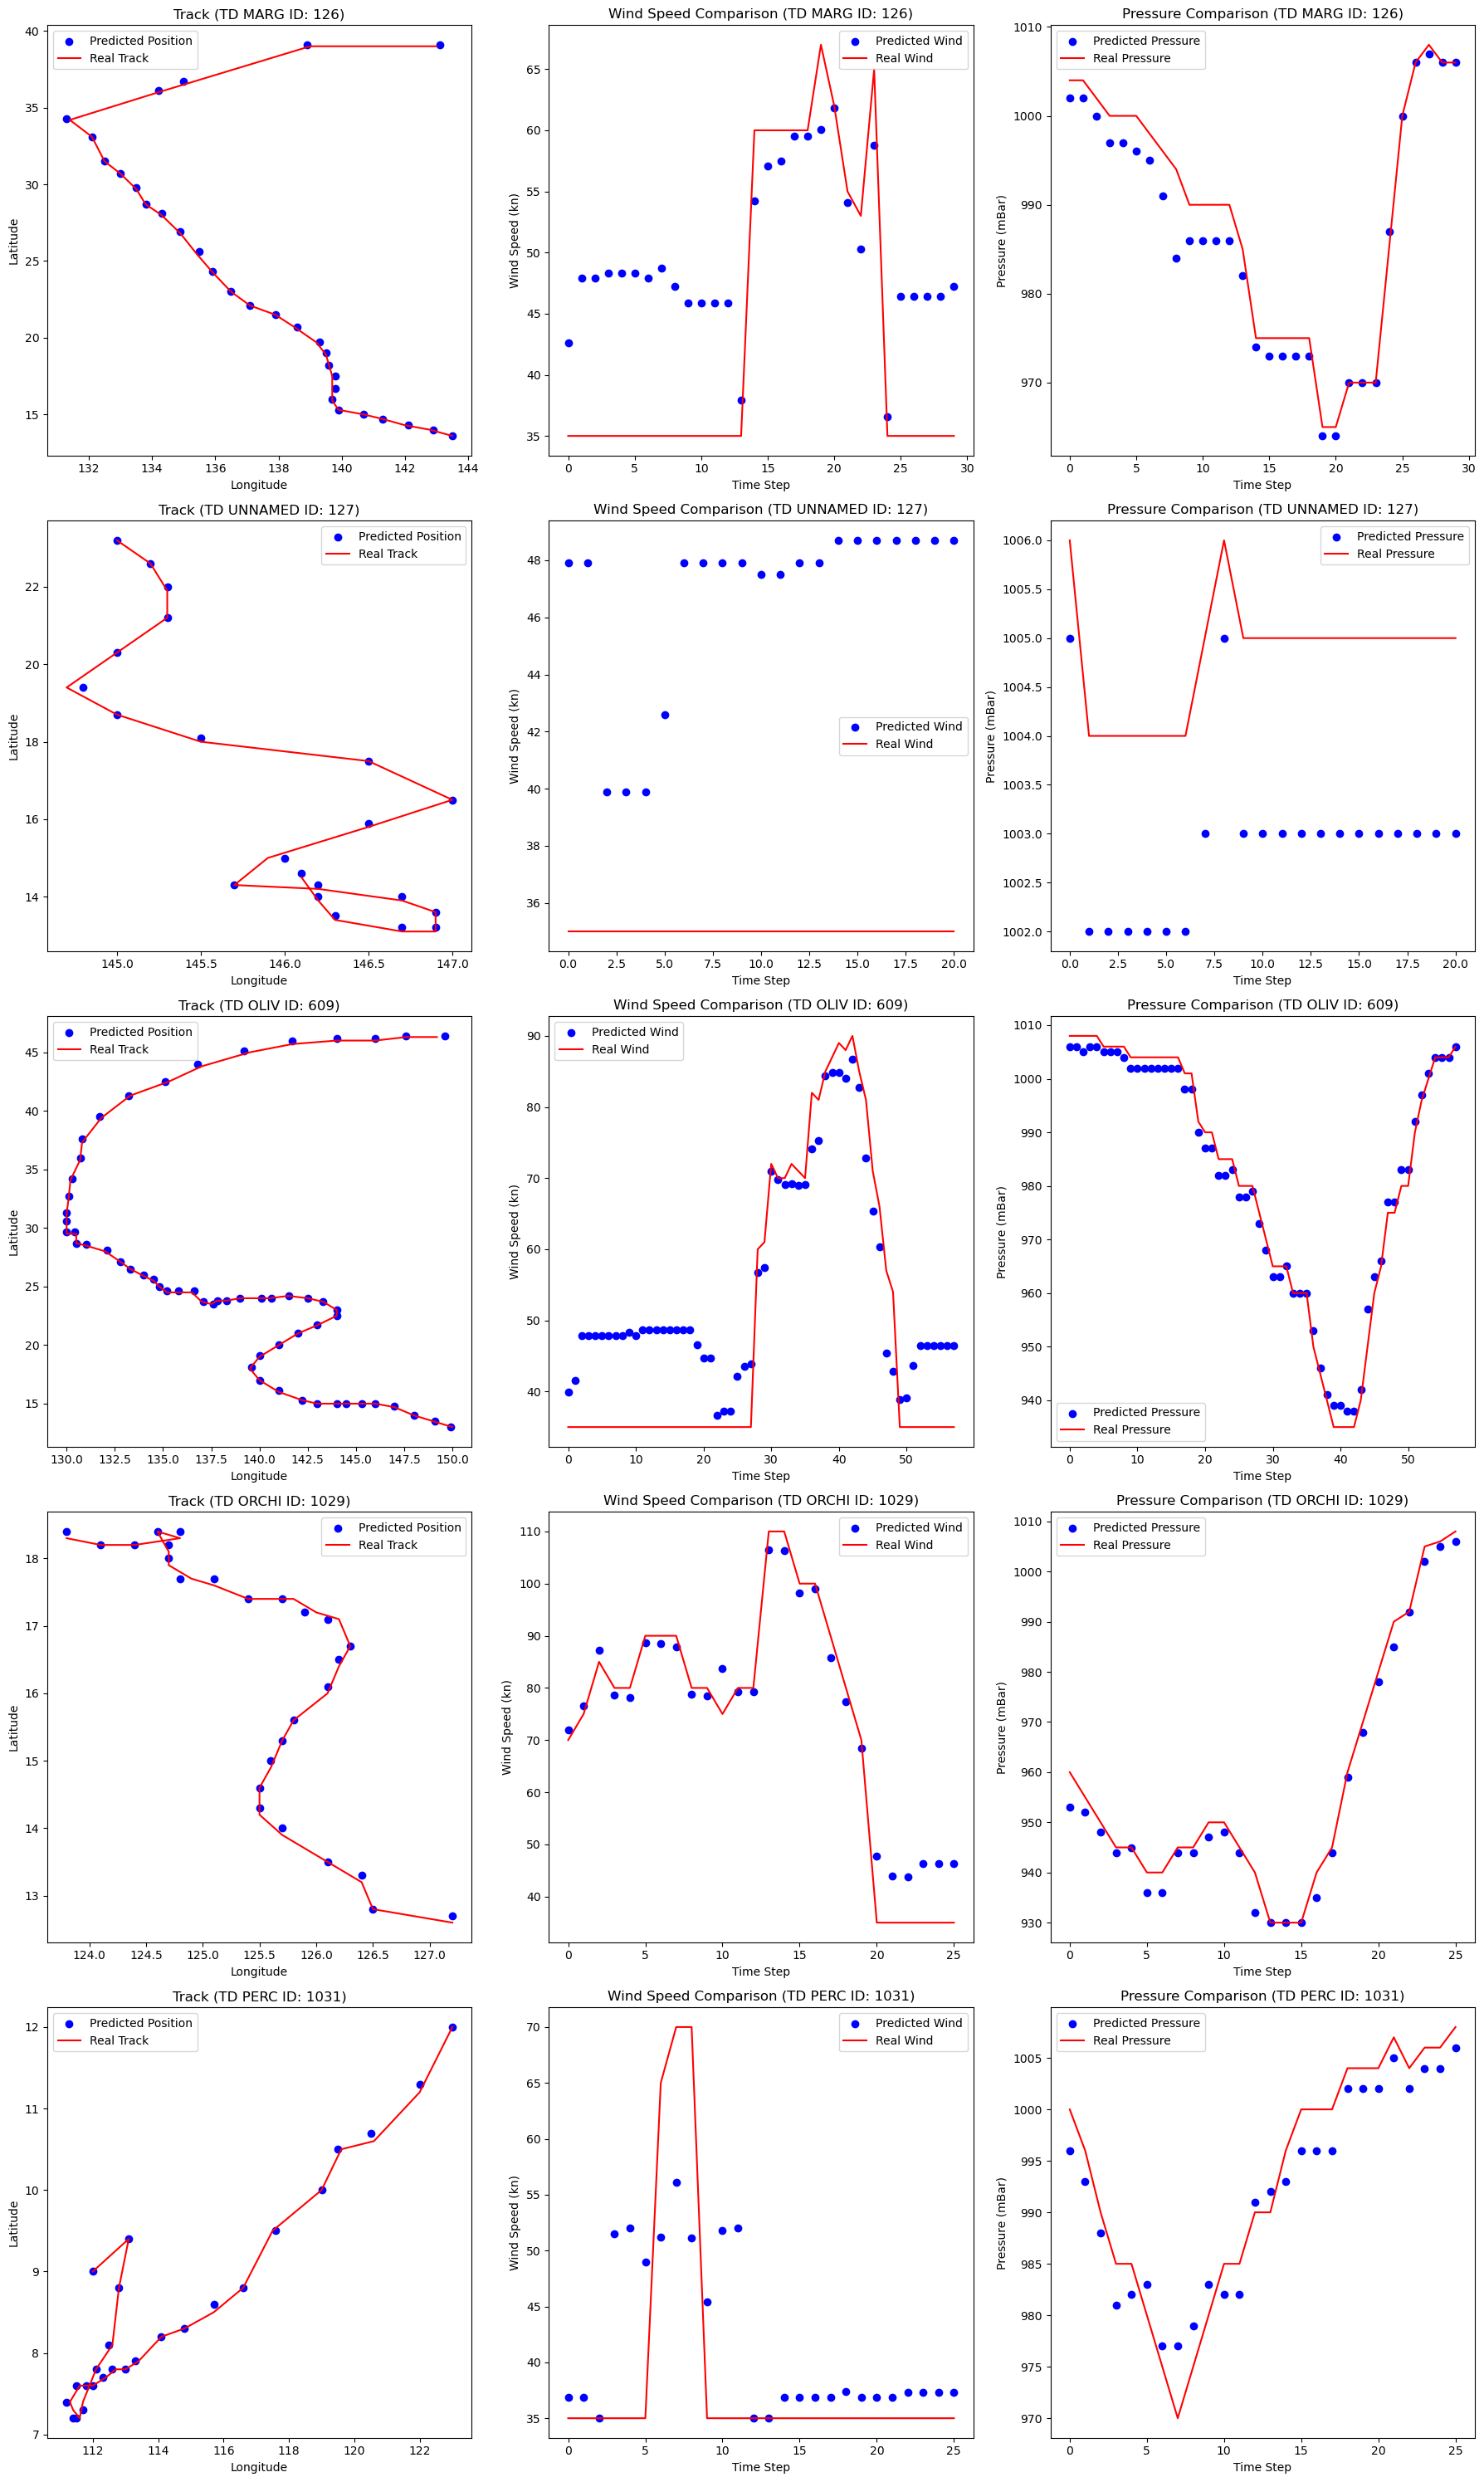

In [73]:
plot_tds(jma, X_test, model=jma_pred_pipeline_rf, n_samples=3, random_state=97)

In [74]:
X_pred

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
1952-10-11 12:00:00,41,ROS,41.5,160.0,35,1012,1,15.8,108.0


In [75]:
X_expected

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
1952-10-11 18:00:00,41,ROS,41.0,162.0,35,1014,1,15.1,90.0


In [76]:
manage_prediction(X_pred, jma_pred_pipeline_rf)

(41.8, 160.1, 47.9, 1012, 5.7, 9)

In [78]:
df_ = create_real_pred_df(jma, X_test, model=jma_pred_pipeline_rf, n_samples=3, random_state=97)

In [80]:
df_pred = jma[jma.group == 1031]

In [90]:
df_pred = df_pred[df_pred.group == 1031].copy()

X_pred = df_pred[1:2]
X_expected = df_pred[2:3]

In [91]:
X_pred


,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
1983-11-18 18:00:00,1031,PERC,9.0,112.0,35,1000,1,11.6,70.0


In [92]:
X_expected

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg
date,,,,,,,,,
1983-11-19,1031,PERC,9.4,113.1,35,996,1,6.7,206.0


In [101]:
manage_prediction(X_pred, jma_pred_pipeline_sgd)

(9.3, 111.9, 35.5, 998, 1.6, 353)

In [98]:
df_trn[df_trn.group == 1031].columns

Index(['group', 'name', 'lat', 'lon', 'max_wind_kn', 'min_pressure_mBar',
       'enso', 'velocity_kn', 'direction_deg', 'direction_sin',
       'direction_cos', 'x', 'y', 'z', 'next_x', 'next_y', 'next_z',
       'next_max_wind_kn', 'next_min_pressure_mBar', 'next_velocity_kn',
       'next_direction_sin', 'next_direction_cos'],
      dtype='object')

In [99]:
df_trn[df_trn.group == 1031]

,group,name,lat,lon,max_wind_kn,min_pressure_mBar,enso,velocity_kn,direction_deg,direction_sin,...,y,z,next_x,next_y,next_z,next_max_wind_kn,next_min_pressure_mBar,next_velocity_kn,next_direction_sin,next_direction_cos
date,,,,,,,,,,,,,,,,,,,,,
1983-11-18 12:00:00,1031,PERC,9.5,112.5,35,1004,1,7.0,225.0,-0.707107,...,0.911209,0.165048,-0.369995,0.915769,0.156434,35.0,1000.0,11.6,0.939693,3.420201e-01
1983-11-18 18:00:00,1031,PERC,9.0,112.0,35,1000,1,11.6,70.0,0.939693,...,0.915769,0.156434,-0.387069,0.907470,0.163326,35.0,996.0,6.7,-0.438371,-8.987940e-01
1983-11-19 00:00:00,1031,PERC,9.4,113.1,35,996,1,6.7,206.0,-0.438371,...,0.907470,0.163326,-0.382954,0.911011,0.152986,35.0,990.0,7.3,-0.275637,-9.612617e-01
1983-11-19 06:00:00,1031,PERC,8.8,112.8,35,990,1,7.3,196.0,-0.275637,...,0.911011,0.152986,-0.380461,0.914000,0.140901,35.0,985.0,5.8,-0.857167,-5.150381e-01
1983-11-19 12:00:00,1031,PERC,8.1,112.6,35,985,1,5.8,239.0,-0.857167,...,0.914000,0.140901,-0.372743,0.917956,0.135716,35.0,985.0,5.6,-0.707107,-7.071068e-01
1983-11-19 18:00:00,1031,PERC,7.8,112.1,35,985,1,5.6,225.0,-0.707107,...,0.917956,0.135716,-0.366667,0.921394,0.128796,35.0,980.0,2.2,-0.438371,-8.987940e-01
1983-11-20 00:00:00,1031,PERC,7.4,111.7,35,980,1,2.2,206.0,-0.438371,...,0.921394,0.128796,-0.365222,0.922445,0.125333,65.0,975.0,2.2,-0.891007,4.539905e-01
1983-11-20 06:00:00,1031,PERC,7.2,111.6,65,975,1,2.2,297.0,-0.891007,...,0.922445,0.125333,-0.361919,0.923509,0.127065,70.0,970.0,1.4,-0.707107,7.071068e-01
1983-11-20 12:00:00,1031,PERC,7.3,111.4,70,970,1,1.4,315.0,-0.707107,...,0.923509,0.127065,-0.360226,0.923931,0.128796,70.0,975.0,3.6,0.829038,5.591929e-01
